<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models

## Notebook Setup

Run this cell every time the notebook is opened to mount the drive.

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If any import statements cannot be resolved, run this cell to re-install those packages.

In [ ]:
%pip install scanpy
%pip install anndata
%pip install pydeseq2
#%pip install gseapy

Import statements

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
# import matplotlib.pyplot as plt
# etc.

## Read in Kim et al scRNA-seq 10X output files and save as .h5ad.gz files (perform once)

**Read in the scRNA-seq data for Kim et al dataset day 53 untreated sample and day 53 acute fentanyl treatment sample, add metadata and prepend cell barcodes with unique identifiers, and save each sample as a separate `.h5ad.gz` file. Then merge the datasets and save the merged dataset as a `h5ad.gz` file as well.**

The original sample IDs are KH001 for the day 53 untreated sample and KH002 for the day 53 acute fentanyl treatment sample. Each sample has its own folder containing 3 compressed (`.gz`) files, which are the 10X Genomics CellRanger output files:

*   `matrix.mtx.gz` is a count matrix where rows are single cells, columns are genes, and each cell is the read count of that gene in that cell
*   `barcodes.tsv.gz` contains the cell barcodes (each cell is labeled with a unique barcode, which is used as an identifier)
*   `features.tsv.gz` contains the gene names

For each of the 2 samples, we will first use `scanpy.read_10x_mtx()` to read the 3 files into a single `AnnData` object that contains the cell-by-gene matrix and associated metadata (`obs` = barcodes, `var` = features). We will add columns to the `obs` attribute, `Sample` indicating the sample name and `condition` indicating the treatment group of the sample (untreated or fentanyl). In preparation for merging these samples into one `AnnData` object later, we will prepend the cell barcodes with a sample description, "d53_ut" for untreated samples and "d53_fty" for treated samples. Then we will save each sample `AnnData` object as a compressed `.h5ad.gz` file for later use.

In [ ]:
# sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH001_Day53_Untreated"
# adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
# adata1.obs["Sample"] = "kim_day53_untreated"
# adata1.obs["condition"] = "untreated"
# adata1.obs.index = [f"d53_ut_{barcode}" for barcode in adata1.obs.index]
# adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ut.h5ad.gz", compression="gzip")

# sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH002_Day53_FTY_Acute"
# adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
# adata2.obs["Sample"] = "kim_d53_fty_acute"
# adata2.obs["condition"] = "untreated"
# adata2.obs.index = [f"d53_fty_{barcode}" for barcode in adata2.obs.index]
# adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_fty.h5ad.gz", compression="gzip")

Now we will merge the two samples into one `AnnData` object and save the merged dataset as a `.h5ad.gz` file as well.

In [ ]:
# adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample1", "sample2"])
# adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

## QC and preprocessing on Kim et al scRNA-seq dataset

We will read in the Kim et al combined dataset as an `AnnData` object using `scanpy.read_h5ad()`.

In [21]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz")

Before QC and preprocessing, we will create a `counts` layer in the `AnnData` object to store the raw counts.

In [23]:
kim_d53.layers["counts"] = kim_d53.X.copy()

We will follow the `scanpy` tutorial for QC and preprocessing. We will first calculate common QC metrics.


In [24]:
kim_d53.var["mt"] = kim_d53.var_names.str.startswith("MT-") # mitochondrial genes
sc.pp.calculate_qc_metrics(kim_d53, qc_vars=["mt"], inplace=True, log1p=False)

We will now inspect violin plots for number of genes expressed, total counts per cell, and percentage of counts in mitochondrial genes.

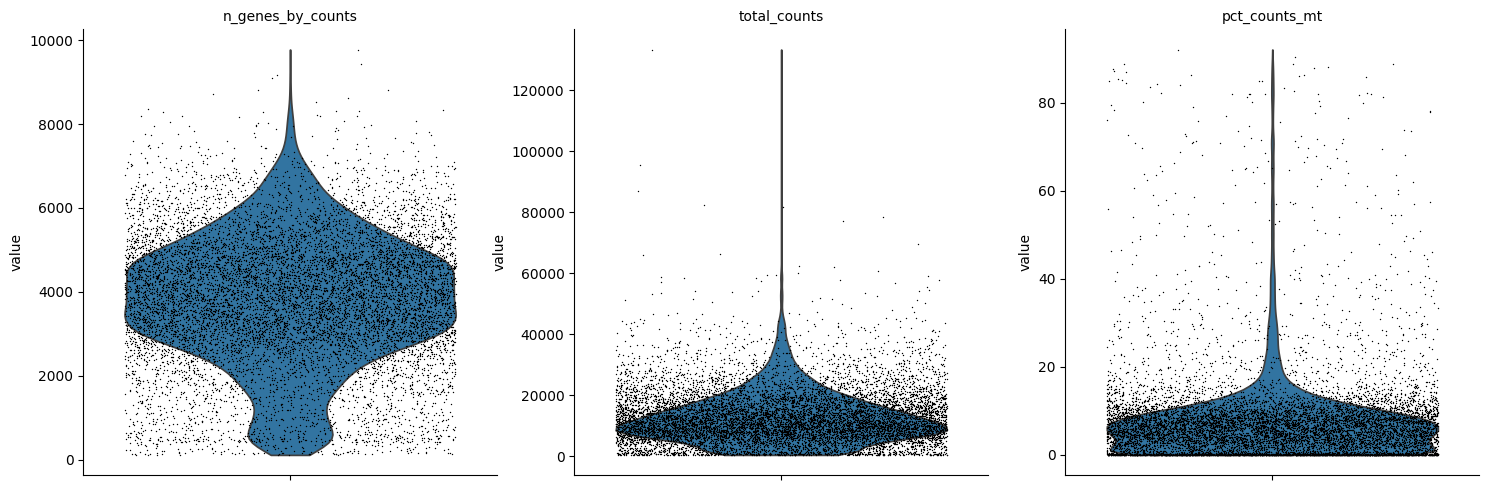

In [25]:
sc.pl.violin(
    kim_d53,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We can also inspect a joint scatterplot of all 3 metrics.

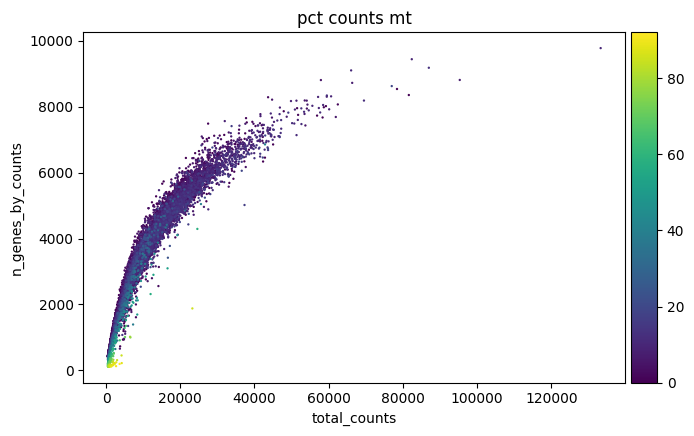

In [26]:
sc.pl.scatter(kim_d53, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

We will filter out cells with fewer than 100 genes expressed and genes expressed in fewer than 3 cells; these thresholds are used in the `scanpy` tutorial and are reasonable for this dataset based on the violin plots. Additionally, we will filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [27]:
print(f"Number of cells before filtering: {kim_d53.n_obs}")
print(f"Number of genes before filtering: {kim_d53.n_vars}")

Number of cells before filtering: 10630
Number of genes before filtering: 33538


In [28]:
sc.pp.filter_cells(kim_d53, min_genes=100)
sc.pp.filter_genes(kim_d53, min_cells=3)
kim_d53 = kim_d53[kim_d53.obs["pct_counts_mt"] <= 20]
print(f"Number of cells after filtering: {kim_d53.n_obs}")
print(f"Number of genes after filtering: {kim_d53.n_vars}")

Number of cells after filtering: 10029
Number of genes after filtering: 24368


We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [29]:
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

## Pseudobulk representation and differential expression analysis on Kim et al scRNA-seq dataset

The following function creates a pseudobulk representation of a multi-sample `AnnData` object. Each sample is randomly split into a given number of pseudoreplicates.

In [33]:
def pseudobulk_with_pseudoreps(adata, n):
  """
  Generate the pseudobulk representation of adata with n pseudoreplicates per
  sample, using randomly chosen cells for each pseudoreplicate.
  """
  all_pseudoreps = list()
  for sample in adata.obs.Sample.unique():
    # Get sample cell subset
    samp_cell_subset = adata[adata.obs.Sample == sample]
    # Use raw data
    if "counts" in samp_cell_subset.layers:
      samp_cell_subset.X = samp_cell_subset.layers["counts"]
    # Split indices into n random pseudoreplicates
    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), n)
    # Create a single-row AnnData object for each pseudoreplicate
    for i, pseudo_rep in enumerate(indices):
      X = samp_cell_subset[indices[i]].X.sum(axis = 0)
      rep_adata = sc.AnnData(X = np.asarray(samp_cell_subset[indices[i]].X.sum(axis = 0)),
                            var = samp_cell_subset[indices[i]].var[[]])
      rep_adata.obs_names = [sample + '_' + str(i)]
      rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
      rep_adata.obs['replicate'] = i
      all_pseudoreps.append(rep_adata)
  # Combine all pseudoreplicates into one AnnData object
  pseudobulk = sc.concat(all_pseudoreps)
  return pseudobulk

We will run this function to generate two pseudobulk datasets for comparison: one with 50 pseudoreplicates x ~100 cells per pseudoreplicate, and one with 10 pseudoreps x ~500 cells per pseudorep.

In [ ]:
random.seed(42)
pseudobulk50 = pseudobulk_with_pseudoreps(kim_d53, 50)
pseudobulk10 = pseudobulk_with_pseudoreps(kim_d53, 10)

We will now perform differential expression analysis using `PyDESeq2`. We will create two `DeseqDataSet` objects, one for each pseudobulk representation, and use `scanpy` to remove genes that are not expressed in any cells.

In [ ]:
# Generate count matrices to see if creating DeseqDataSet objects with pandas dataframes instead of AnnData objects is faster
# counts50 = pd.DataFrame(pseudobulk50.X, columns = pseudobulk50.var_names)
# counts10 = pd.DataFrame(pseudobulk10.X, columns = pseudobulk50.var_names)

In [29]:
dds50 = DeseqDataSet(adata=pseudobulk50, design='condition')
dds10 = DeseqDataSet(adata=pseudobulk10, design='condition')
sc.pp.filter_genes(dds50, min_cells = 1)
sc.pp.filter_genes(dds10, min_cells = 1)

Now we are ready to perform differential gene expression analysis on each pseudobulk dataset. We will fit dispersions and log fold changes (LFCs) to each dataset.

In [31]:
dds50.deseq2()
dds10.deseq2()

Fitting size factors...
... done in 0.15 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 29.33 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 49.43 seconds.

Fitting LFCs...
... done in 18.54 seconds.

Calculating cook's distance...
... done in 0.33 seconds.

Replacing 55 outlier genes.

Fitting dispersions...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 0.14 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 31.69 seconds.

Fitting dispersion trend curve...
... done in 1.27 seconds.

Fitting MAP dispersions...
... done in 37.26 seconds.

Fitting LFCs...
... done in 17.36 seconds.

Calculating cook's distance...
... done in 0.07 seconds.

Replacing 25 outlier genes.

Fitting dispersions...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...
... done in 0.09 seconds.



Now we will run statistical tests to compute p-values and adjusted p-values for differential expression.

In [ ]:
dstats50 = DeseqStats(dds50, contrast=("condition", "fentanyl", "untreated"))
dstats50.summary()
ds50_df = dstats50.results_df
ds50_df.sort_values('stat', ascending = False)

In [44]:
dstats10 = DeseqStats(dds10, contrast=("condition", "fentanyl", "untreated"))
dstats10.summary()
ds10_df = dstats10.results_df
ds10_df.sort_values('stat', ascending = False)

Running Wald tests...
... done in 8.65 seconds.



Log2 fold change & Wald test p-value: condition fentanyl vs untreated
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
MIR1302-2HG    0.151638        0.318674  2.019748  0.157779  0.874631   
OR4F5          0.100630        0.030137  2.524020  0.011940  0.990474   
AL627309.1     3.335001        0.331801  0.420362  0.789322  0.429924   
AL627309.3     0.246856        0.318674  1.797201  0.177317  0.859260   
AL627309.4     0.099261       -0.546939  2.540081 -0.215324  0.829515   
...                 ...             ...       ...       ...       ...   
AC007325.4    65.695558       -0.090451  0.092369 -0.979240  0.327461   
AC007325.2     0.150455        0.318674  2.023182  0.157511  0.874842   
AC023491.2     0.099441        0.030137  2.531598  0.011904  0.990502   
AC004556.1   152.064215        0.281689  0.062628  4.497832  0.000007   
AC240274.1    59.309009        0.195539  0.101008  1.935877  0.052883   

                 padj  
MIR1302-2HG       NaN  
OR4F5

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SRSF6,538.590890,0.645338,0.036103,17.874817,1.852828e-71,2.988982e-67
NPAS4,165.098189,0.949871,0.062122,15.290293,8.874981e-53,7.158560e-49
SRSF3,2961.182885,0.326373,0.021530,15.158961,6.610684e-52,3.554785e-48
RBM3,884.426893,0.387308,0.027782,13.941175,3.560316e-44,8.205003e-41
BDNF,492.217897,0.800811,0.060450,13.247572,4.660353e-40,7.518082e-37
...,...,...,...,...,...,...
ANP32A,639.096827,-0.407062,0.030507,-13.343220,1.297329e-40,2.325390e-37
LAPTM4A,1382.112974,-0.334099,0.024780,-13.482792,1.974899e-41,3.982384e-38
BTG3,695.727412,-0.513858,0.036377,-14.126033,2.625209e-45,7.058311e-42
TCEAL9,1023.065957,-0.395699,0.026583,-14.885387,4.101050e-50,1.323163e-46


In [65]:
print("Pseudobulk dataset with 50 pseudoreplicates, sorted by 'log2FoldChange'")
ds50_df.sort_values('log2FoldChange', ascending = False)

Pseudobulk dataset with 50 pseudoreplicates, sorted by 'log2FoldChange'


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
COL3A1,16.291167,5.633839,0.666233,8.456260,2.760891e-17,3.227988e-15
MGP,8.359467,5.524626,0.762366,7.246680,4.271109e-13,2.258694e-11
OGN,3.432409,5.249856,1.019872,5.147561,2.638949e-07,4.419633e-06
COL1A1,32.377149,4.538260,0.521426,8.703556,3.216435e-18,4.352824e-16
DCN,5.246337,3.634109,0.733601,4.953798,7.277895e-07,1.077392e-05
...,...,...,...,...,...,...
TNK2-AS1,0.596593,-2.110078,1.080311,-1.953214,5.079430e-02,1.342521e-01
AGTR1,6.495542,-2.140908,0.414249,-5.168166,2.364029e-07,4.026815e-06
AL391650.1,0.969138,-2.143851,0.458354,-4.677281,2.907041e-06,3.676476e-05
APOBEC3A,0.851184,-2.215502,0.683432,-3.241732,1.188055e-03,6.572783e-03


In [63]:
print("Pseudobulk dataset with 50 pseudoreplicates, sorted by 'stat'")
ds50_df.sort_values('stat', ascending = False)

Pseudobulk dataset with 50 pseudoreplicates, sorted by 'stat'


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SRSF6,106.999861,0.640848,0.032600,19.658052,4.933107e-86,8.478531e-82
EPC1,163.219318,0.418829,0.024716,16.946002,2.059960e-64,1.180151e-60
ACTB,4119.758341,0.282375,0.016997,16.612880,5.622737e-62,2.415949e-58
RBM3,175.393494,0.382341,0.025509,14.988208,8.768684e-51,2.511789e-47
NPAS4,32.731916,0.945728,0.063345,14.929780,2.109620e-50,5.179719e-47
...,...,...,...,...,...,...
DPYSL2,595.359318,-0.264168,0.018743,-14.094232,4.121078e-45,6.438996e-42
KMT2E,278.414025,-0.308400,0.021672,-14.230572,5.919557e-46,1.130438e-42
ANP32A,126.797748,-0.411290,0.027820,-14.783805,1.863362e-49,4.003201e-46
TOMM20,396.073335,-0.276253,0.018129,-15.237987,1.978735e-52,6.801704e-49


In [59]:
print("Pseudobulk dataset with 10 pseudoreplicates, sorted by 'log2FoldChange'")
ds10_df.sort_values('log2FoldChange', ascending = False)

Pseudobulk dataset with 10 pseudoreplicates


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
OGN,16.873493,7.541855,1.157605,6.515048,7.266662e-11,2.894464e-09
COL3A1,79.741664,5.701844,0.822054,6.936097,4.030796e-12,2.044805e-10
MGP,42.257688,5.626615,0.777677,7.235155,4.649985e-13,2.768028e-11
HOXA10,2.593314,4.526118,1.099309,4.117240,3.834374e-05,NaN
COL1A1,160.456908,4.523385,0.537572,8.414480,3.946426e-17,4.786748e-15
...,...,...,...,...,...,...
AP005233.2,1.183729,-2.615390,0.911707,-2.868675,4.121951e-03,NaN
ROR1-AS1,0.590789,-2.675198,2.423748,-1.103744,2.697042e-01,NaN
HCG22,1.288873,-2.750104,0.906266,-3.034543,2.409004e-03,NaN
AC004490.1,0.684044,-2.888021,1.832498,-1.576003,1.150252e-01,NaN


In [64]:
print("Pseudobulk dataset with 10 pseudoreplicates, sorted by 'stat'")
ds10_df.sort_values('stat', ascending = False)

Pseudobulk dataset with 10 pseudoreplicates, sorted by 'stat'


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SRSF6,538.590890,0.645338,0.036103,17.874817,1.852828e-71,2.988982e-67
NPAS4,165.098189,0.949871,0.062122,15.290293,8.874981e-53,7.158560e-49
SRSF3,2961.182885,0.326373,0.021530,15.158961,6.610684e-52,3.554785e-48
RBM3,884.426893,0.387308,0.027782,13.941175,3.560316e-44,8.205003e-41
BDNF,492.217897,0.800811,0.060450,13.247572,4.660353e-40,7.518082e-37
...,...,...,...,...,...,...
ANP32A,639.096827,-0.407062,0.030507,-13.343220,1.297329e-40,2.325390e-37
LAPTM4A,1382.112974,-0.334099,0.024780,-13.482792,1.974899e-41,3.982384e-38
BTG3,695.727412,-0.513858,0.036377,-14.126033,2.625209e-45,7.058311e-42
TCEAL9,1023.065957,-0.395699,0.026583,-14.885387,4.101050e-50,1.323163e-46


In both cases, we are seeing absurdly low p-values (up to ~10^-86) and abnormally high LFCs (up to ~7) due to the inflated statistical power of the pseudoreplicates. We will generate another pseudobulk dataset with these changes:
-  Perform QC first
-  3 pseudoreplicates x ~1667 cells
-  Filter out genes that are expressed in fewer than 3 cells, since low-expressed genes tend to have highly variable LFCs

We can also try adding `orig_sample` as a design factor in the experiment to ensure `PyDESeq2` does not treat pseudoreplicates from the same sample as fully independent.

Read in the QC-passed combined dataset:

In [31]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

Create the new pseudobulk dataset with 3 pseudoreplicates and create the DeseqDataSet object:

In [35]:
random.seed(42)
pb3 = pseudobulk_with_pseudoreps(kim_d53, 3)

Create the DeseqDataSet object and fit dispersions and LFCs:

In [36]:
dds3 = DeseqDataSet(adata=pb3, design="condition")
dds3.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 26.61 seconds.

Fitting dispersion trend curve...
... done in 1.01 seconds.

Fitting MAP dispersions...
... done in 35.80 seconds.

Fitting LFCs...
... done in 28.13 seconds.

Calculating cook's distance...
... done in 0.09 seconds.

Replacing 0 outlier genes.



Run statistical analysis:

In [38]:
dstats3 = DeseqStats(dds3, contrast=("condition", "fentanyl", "untreated"))
dstats3.summary()

Running Wald tests...
... done in 8.46 seconds.



Log2 fold change & Wald test p-value: condition fentanyl vs untreated
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
MIR1302-2HG    0.503803        0.946402  2.619814  0.361248  0.717914   
AL627309.1    11.139746        0.349249  0.555495  0.628716  0.529535   
AL627309.3     0.828803        0.638803  2.088224  0.305907  0.759675   
AL669831.5   443.004058       -0.255952  0.090079 -2.841405  0.004492   
FAM87B         2.326061       -0.379968  1.186681 -0.320194  0.748821   
...                 ...             ...       ...       ...       ...   
AL592183.1     1.309294       -2.653853  1.923643 -1.379597  0.167711   
AC007325.4   217.299600       -0.085002  0.120490 -0.705471  0.480517   
AC007325.2     0.501198        0.945699  2.762172  0.342375  0.732069   
AC004556.1   504.046161        0.295293  0.081353  3.629783  0.000284   
AC240274.1   191.811089        0.173409  0.134727  1.287122  0.198052   

                 padj  
MIR1302-2HG       NaN  
AL627

View results:

In [39]:
ds3_df = dstats3.results_df
ds3_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
OGN,46.592223,9.009843,1.959131,4.598897,4.247341e-06,1.002589e-04
LINC01965,17.346821,5.707448,2.741923,2.081549,NaN,NaN
COL3A1,245.145519,5.567052,0.809228,6.879460,6.008004e-12,6.825190e-10
MAGEA12,4.208020,5.542026,2.079523,2.665046,7.697779e-03,NaN
MGP,126.133577,5.471183,0.585543,9.343772,9.296219e-21,4.153412e-18
...,...,...,...,...,...,...
TNK2-AS1,30.421328,-4.625284,1.059995,-4.363498,1.279993e-05,NaN
APOF,6.307549,-5.080113,2.318475,-2.191144,2.844137e-02,NaN
AC091917.3,3.554449,-5.254663,4.212255,-1.247470,2.122250e-01,NaN
LINC01299,35.377211,-6.097127,2.173536,-2.805165,NaN,NaN


In [41]:
ds3_df.sort_values('stat', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ACTB,68735.351139,0.300364,0.019056,15.762022,5.678647e-56,7.934774e-52
BDNF,1597.279731,0.812632,0.054902,14.801461,1.433351e-49,1.001410e-45
SRSF6,1772.114580,0.660891,0.046290,14.277217,3.034818e-46,1.060138e-42
MTRNR2L8,44191.136071,0.277082,0.020419,13.569982,6.033711e-42,1.686181e-38
SRSF3,9810.861161,0.335266,0.025532,13.131176,2.182401e-39,5.082449e-36
...,...,...,...,...,...,...
NKX2-1,970.879809,-0.714856,0.066498,-10.750075,5.921369e-27,6.364560e-24
TCEAL9,3374.453584,-0.387258,0.034963,-11.076108,1.638408e-28,1.907790e-25
AP2B1,4870.016648,-0.345182,0.030760,-11.221678,3.191561e-29,4.955075e-26
NRN1,4387.936005,-0.387695,0.034271,-11.312477,1.138305e-29,1.988193e-26


We are still seeing p-values and LFCs that indicate statistical issues with the pseudobulk, so we will try adding `orig_sample` as a design factor to the DeseqDataSet.

## Read in Ho et al files

In [ ]:
counts_raw = pd.read_table("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE210206_counts.txt")
counts_raw.head()
# transpose
# filter
# blah

,gene_symbol,OFO1003B1,OFO1003B2,OFO1003O1,OFO1003O2,OFO1003V1,OFO1003V2,OFO1004B1,OFO1004B2,OFO1004O1,OFO1004O2,OFO1004V1,OFO1004V2,OFO1005B1,OFO1005B2,OFO1005O1,OFO1005O2,OFO1005V1,OFO1005V2
0,DDX11L1,1,0,0,0,0,0,0,2,2,0,0,0,1,0,0,0,0,1
1,WASH7P,448,437,412,510,637,686,263,300,247,329,256,163,373,367,182,222,252,242
2,MIR6859-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,MIR6859-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FAM138A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
